<a href="https://colab.research.google.com/github/Reem-Almasri/flowering_time/blob/main/cr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/mariiabav/AIO_vigna.git

Cloning into 'AIO_vigna'...
remote: Enumerating objects: 1036, done.
remote: Counting objects: 100% (1036/1036), done.
remote: Compressing objects: 100% (1016/1016), done.
remote: Total 1036 (delta 20), reused 1034 (delta 19), pack-reused 0
Receiving objects: 100% (1036/1036), 409.30 KiB | 4.31 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [3]:
!git clone https://github.com/Tihon99/AIO_vigna-master_updated.git

Cloning into 'AIO_vigna-master_updated'...
remote: Enumerating objects: 2317, done.
remote: Counting objects: 100% (2317/2317), done.
remote: Compressing objects: 100% (2282/2282), done.
remote: Total 2317 (delta 49), reused 2303 (delta 35), pack-reused 0
Receiving objects: 100% (2317/2317), 2.20 MiB | 16.30 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [4]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [5]:
import h5py
import numpy as np
from PIL import Image
import scipy
import logging
import seaborn as sns
import os
import cv2 as cv
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate)
from keras.layers import BatchNormalization
from keras.utils import to_categorical
import keras_tuner as kt
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import regularizers

In [6]:
# original_classes = [
#     [0, 23, 31],
#     [1, 34, 40],  # !!!
#     [2, 41, 47],
#     [3, 48, 54],
#     [4, 55, 61],
#     [5, 62, 68],
#     [6, 69, 75],
#     [7, 76, 83],
#     [8, 84, 90],
#     [9, 91, 97],
#     [10, 98, 105],
#     [11, 106, 157],  # !!!
#     [12, 175, 181],
#     [13, 182, 188],
#     [14, 189, 195],
#     [15, 198, 204],
#     [16, 205, 211],
#     [17, 212, 218],
#     [18, 230, 250],  # !!!
# ]

# balanced_classes = [
#     [0, 23, 37],
#     [1, 38, 41],
#     [2, 42, 45],
#     [3, 46, 48],
#     [4, 49, 52],
#     [5, 53, 55],
#     [6, 56, 63],
#     [7, 64, 78],
#     [8, 79, 93],
#     [9, 94, 108],
#     [10, 109, 157],  # !!!
#     [11, 175, 181],
#     [12, 182, 188],
#     [13, 189, 204],
#     [14, 205, 218],
#     [15, 230, 250],  # !!!
# ]

# large_classes = [
#     [0, 23, 43],
#     [1, 44, 50],
#     [2, 51, 60],
#     [3, 60, 70],
#     [4, 71, 150],
#     [5, 151, 200],
#     [6, 201, 250]
# ]

# predicted_classes = [
#     [0, 23, 40],
#     [1, 41, 42],
#     [2, 43, 44],
#     [3, 45, 47],
#     [4, 48, 52],
#     [5, 53, 59],
#     [6, 60, 75],
#     [7, 76, 101],
#     [8, 102, 156],
#     [9, 157, 188],
#     [10, 189, 250]
# ]

def load_images_from_folder(folder):
    labels = []
    images = []
    days = []
    r_labels=[]
    im=[]
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            aio_plant = filename.split("_")
            flowering_time = aio_plant[2].split(".")[0]
            im.append(np.asarray(img).astype(np.float32))
            r_labels.append(np.uint8(flowering_time))
    #         for i in predicted_classes:
    #             if int(flowering_time) in range(i[1], i[2] + 1):
    #                 labels.append(np.uint8(i[0]))
    #                 images.append(np.asarray(img).astype(np.float32))
    #                 days.append(int(flowering_time))
    # return np.asarray(images), np.asarray(labels), np.array(im), np.array(r_labels)
    return np.array(im), np.array(r_labels)

In [7]:
def plot_confusion(confusion_mat):
    ax = sns.heatmap(confusion_mat, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix with labels for all vigna\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    fig = ax.get_figure()
    fig.savefig('./confusion_matrix-all.png')
    plt.show()

    plt.matshow(confusion_mat)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_accuracy(history, fold):
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(80)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Точность на обучении')
    plt.plot(epochs_range, val_acc, label='Точность на валидации')
    plt.legend(loc='lower right')
    plt.title('Точность')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Потери на обучении')
    plt.plot(epochs_range, val_loss, label='Потери на валидации')
    plt.legend(loc='upper right')
    plt.title('Потери')

    plt.savefig('./' + str(fold) + '_vigna_turned.png')
    plt.show()

In [8]:
#1
def build_model(hp):
    inputs1 = keras.Input(shape=(5, 28, 3))
    inputs2 = keras.Input(shape=(5, 28, 3))
    c = concatenate([inputs1, inputs2])

    c = Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1), activation=hp.Choice(
                                        'first_conv2d_activation',
                                        ['relu', 'tanh'],))(c)
    if hp.Boolean("need_batch_norm_after_first_conv2d"):
      c=BatchNormalization()(c)

    c=MaxPooling2D(pool_size=(2, 2))(c)
    c=Conv2D(hp.Int('second_conv2d_out_channels',
        min_value=32, max_value=64, step=32,),
             kernel_size=(3, 3), padding='same', strides=(1, 1), input_shape=(2, 11, 32),
        activation=hp.Choice('second_conv2d_activation',['relu', 'tanh'],))(c)
    if hp.Boolean("need_batch_norm_after_second_conv2d"):
       c=BatchNormalization()(c)
    c=MaxPooling2D(pool_size=(2, 2))(c)
    c=Flatten(name='flatten')(c)
    c=Dense(128, activation='relu', kernel_regularizer='l1_l2')(c)
    c=Dropout(0.5)(c)
    # Outputs
    r_output =Dense(1, activation='linear',kernel_regularizer='l1_l2', name='Regression')(c)
    c_output=Dense(7, activation='softmax',kernel_regularizer='l1_l2', name="Classification")(c)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=[c_output, r_output], name='model')

    model.compile(
    loss={
        "Classification": keras.losses.CategoricalCrossentropy(),
        "Regression": keras.losses.Huber(delta=0.5),},
    metrics = {
        "Classification": 'accuracy',
        "Regression": 'mse'},
        optimizer=keras.optimizers.RMSprop(1e-3),
    loss_weights={
          "Classification": 0.8,
          "Regression": 0.2 })
    keras.utils.plot_model(model, "model.png", show_shapes=True)
    model.summary()
    return model

In [9]:
# 2
# def build_model(hp):
#     inputs1 = keras.Input(shape=(5, 28, 3))
#     inputs2 = keras.Input(shape=(5, 28, 3))
#     c = concatenate([inputs1, inputs2])

#     c = Conv2D(hp.Int('first_conv2d_out_channels', min_value=32, max_value=128, step=32),
#                kernel_size=(3, 3), padding='same', strides=(1, 1),
#                activation=hp.Choice('first_conv2d_activation', ['relu', 'tanh']))(c)

#     if hp.Boolean("need_batch_norm_after_first_conv2d"):
#         c = BatchNormalization()(c)

#     c = MaxPooling2D(pool_size=(2, 2))(c)

#     c = Conv2D(hp.Int('second_conv2d_out_channels', min_value=64, max_value=256, step=64),
#                kernel_size=(3, 3), padding='same', strides=(1, 1),
#                activation=hp.Choice('second_conv2d_activation', ['relu', 'tanh']))(c)

#     if hp.Boolean("need_batch_norm_after_second_conv2d"):
#         c = BatchNormalization()(c)

#     c = MaxPooling2D(pool_size=(2, 2))(c)
#     c = Flatten(name='flatten')(c)
#     c = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(c)
#     c = Dropout(0.5)(c)

#     # Outputs
#     r_output = Dense(1, activation='linear', kernel_regularizer=keras.regularizers.l2(0.001), name='Regression')(c)
#     c_output = Dense(5, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.001), name="Classification")(c)

#     model = keras.Model(inputs=[inputs1, inputs2], outputs=[c_output, r_output], name='model')

#     model.compile(
#         loss={
#             "Classification": keras.losses.CategoricalCrossentropy(),
#             "Regression": keras.losses.Huber(delta=0.01)
#         },
#         metrics={
#             "Classification": 'accuracy',
#             "Regression": 'mse'
#         },
#         optimizer=keras.optimizers.RMSprop(1e-3))

#     keras.utils.plot_model(model, "model.png", show_shapes=True)
#     model.summary()

#     return model

In [10]:
large_classes = [
    [0, 0, 43],
    [1, 44, 50],
    [2, 51, 60],
    [3, 61, 70],
    [4, 71, 150],
    [5, 151, 200],
    [6, 201, 260]
]

# labels to classes:
def to_classes(data):
    classes=[]
    for d in data:
      for i in large_classes:
        if d in range(i[1], i[2]+1):
           classes.append(i[0])
    return np.array(classes)

 # for i in data:
    #   if int(i)<=50:  #256
    #      classes.append(0)
    #   if int(i)>50 and int(i)<=60: #247
    #     classes.append(1)
    #   if int(i)>60 and int(i)<=70: #124
    #     classes.append(2)
    #   if int(i)>70 and int(i)<=120: #154
    #     classes.append(3)
    #   if int(i)>120 and int(i)<=250: #222
    #     classes.append(4)

In [11]:
from re import X
def train():
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    K.set_image_data_format('channels_last')

    # data_images, data_labels, images, labels= load_images_from_folder('/content/AIO_vigna/AIO_summer')
    images, labels= load_images_from_folder('/content/AIO_vigna/AIO_summer')


    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=0.7, test_size=0.3, random_state=42)
    clusters=to_classes(labels)
    train_classes=to_classes(train_labels)
    test_classes=to_classes(test_labels)

    train_vectors = to_categorical(train_classes, 7)
    test_vectors = to_categorical(test_classes, 7)

    plt.hist(clusters, color = 'blue', edgecolor = 'black', bins = int(180/5))
    plt.figure()

    plt.hist(labels, color = 'blue', edgecolor = 'black', bins = int(180/5))


    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=6,
        seed=1234,
        overwrite=True
    )
    tuner.search([train_images, train_images], [train_vectors, train_labels], epochs=80, batch_size=64, validation_split=0.2)
    tuner.results_summary()
    model = tuner.get_best_models()[0]

    num_folds = 15
    batch_size = 64
    verbosity = 1
    acc_per_fold = []
    c_loss_per_fold = []
    r_loss_per_fold = []
    mse_per_fold = []

    # Define the K-fold Cross Validator
    fold_no = 1
    kfold = KFold(n_splits=num_folds, shuffle=True)
    for tr, valid in kfold.split(train_images, train_labels):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        # Train the model
        history= model.fit([train_images[tr], train_images[tr]], [train_vectors[tr], train_labels[tr]],
                                      batch_size=batch_size,
                                      epochs=80,
                                      verbose=verbosity,
                                      validation_split=0.2)

        scores = model.evaluate([train_images[valid], train_images[valid]], [train_vectors[valid], train_labels[valid]], verbose=0)

        c_loss=scores[1]
        r_loss = scores[2]
        mse=scores[4]
        acc=scores[3]

        r_loss_per_fold.append(r_loss)
        mse_per_fold.append(mse)
        acc_per_fold.append(acc*100)
        c_loss_per_fold.append(c_loss)

        fold_no += 1

        predictions=model.predict([test_images, test_images])[1]
        # x=0
        # for i in range(len(test_labels)):
        #   print("Actual:" , test_labels[i], ",Predicted:",np.round(predictions[i]), "  (",predictions[i],")")
        #   if (test_labels[i]==np.round(predictions[i])):
        #      x+=1
        # print('Guessed', x, 'from:', len(test_labels))

        # Plot regression
        plt.figure()
        plt.scatter(test_labels, predictions, color='b')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Regression')
        plt.show()

        cconfusion = confusion_matrix(np.argmax(test_vectors, axis=-1), np.argmax(model.predict([test_images, test_images])[0], axis=-1))
        print(cconfusion)
        ax = sns.heatmap(cconfusion, annot=True, cmap='Blues')
        ax.set_title('Confusion Matrix with labels for all vigna\n\n')
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ')
        fig = ax.get_figure()
        fig.savefig('./confusion_matrix-val.png')
        plt.show()

    img=cv.imread('/content/model.png')
    plt.imshow(img)
    plt.show()

    # list all data in history
    # print(history.history.keys())
    # # summarize history for loss
    plt.plot(history.history['Classification_loss'],color = 'r')
    plt.plot(history.history['Regression_loss'] ,color = 'b')
    plt.plot(history.history['val_Classification_loss'],color = 'g')
    plt.plot(history.history['val_Regression_loss'] ,color = 'y')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train CNN loss', 'Train Regression loss','Test CNN loss', 'Test Regression loss'], loc='center left')
    plt.show()

    print('Accuracy in all folds:', acc_per_fold)
    print('C loss in all folds:', c_loss_per_fold)
    print('Huber in all folds:', r_loss_per_fold)
    print('MSE in all folds:', mse_per_fold)

    # == Provide average scores ==
    print('\nAverage scores for all folds:')
    print(f'> Classification Accuracy: {np.mean(acc_per_fold)} (+/- {np.std(acc_per_fold)})')
    print(f'> Classification Loss: {np.mean(c_loss_per_fold)} (+/- {np.std(c_loss_per_fold)})')
    print(f'> Regression Huber: {np.mean(r_loss_per_fold)} (+/- {np.std(r_loss_per_fold)})')
    print(f'> Regression MSE: {np.mean(mse_per_fold)}')

Trial 6 Complete [00h 00m 22s]
val_loss: 3.085376024246216

Best val_loss So Far: 2.8839099407196045
Total elapsed time: 00h 02m 28s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
first_conv2d_activation: tanh
need_batch_norm_after_first_conv2d: True
second_conv2d_out_channels: 64
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: False
Score: 2.8839099407196045

Trial 5 summary
Hyperparameters:
first_conv2d_activation: relu
need_batch_norm_after_first_conv2d: False
second_conv2d_out_channels: 32
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: True
Score: 3.085376024246216

Trial 3 summary
Hyperparameters:
first_conv2d_activation: tanh
need_batch_norm_after_first_conv2d: False
second_conv2d_out_channels: 64
second_conv2d_activation: tanh
need_batch_norm_after_second_conv2d: True
Score: 3.087270498275757

Trial 2 summary
Hyperparameters:
first_conv2d_a

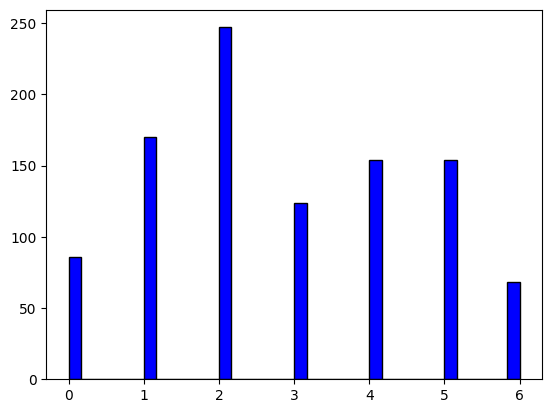

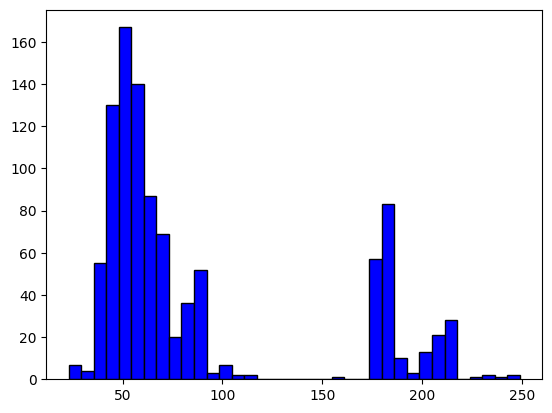

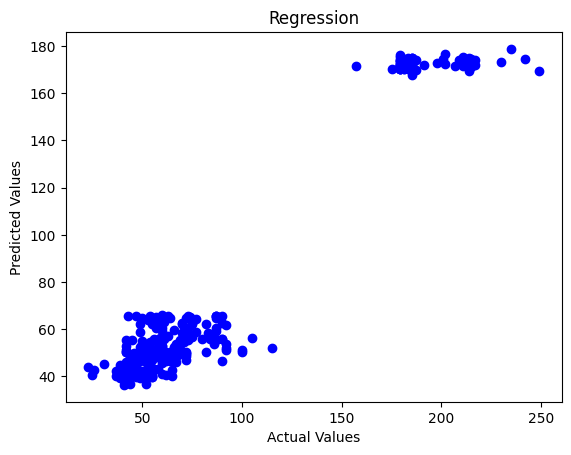

10/10 [==============================] - 0s 2ms/step
[[ 0  0 28  0  0  0  0]
 [ 0  0 41  0  0  0  0]
 [ 0  0 66  0  0  0  0]
 [ 0  0 36  0  0  0  0]
 [ 0  0 52  0  0  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


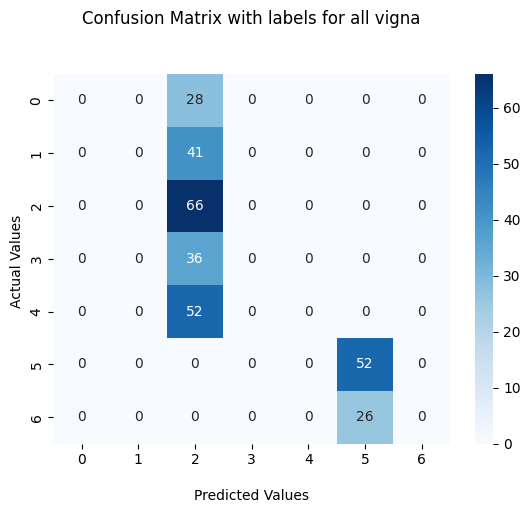

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/80
9/9 [==============================] - 0s 18ms/step - loss: 3.3339 - Classification_loss: 1.3035 - Regression_loss: 7.2320 - Classification_accuracy: 0.3969 - Regression_mse: 391.6552 - val_loss: 2.9102 - val_Classification_loss: 1.2724 - val_Regression_loss: 5.1425 - val_Classification_accuracy: 0.3817 - val_Regression_mse: 151.2825
Epoch 2/80
9/9 [==============================] - 0s 10ms/step - loss: 3.3655 - Classification_loss: 1.2822 - Regression_loss: 7.4653 - Classification_accuracy: 0.4351 - Regression_mse: 458.2699 - val_loss: 2.7816 - val_Classification_loss: 1.3330 - val_Regression_loss: 4.2988 - val_Classification_accuracy: 0.3511 - val_Regression_mse: 120.2466
Epoch 3/80
9/9 [==============================] - 0s 11ms/step - loss: 3.2464 - Classification_loss: 1.2621 - Regression_loss: 6.9671 - Classification_accuracy: 0.4351 - Regression_mse: 389.7676 - val_loss: 2.

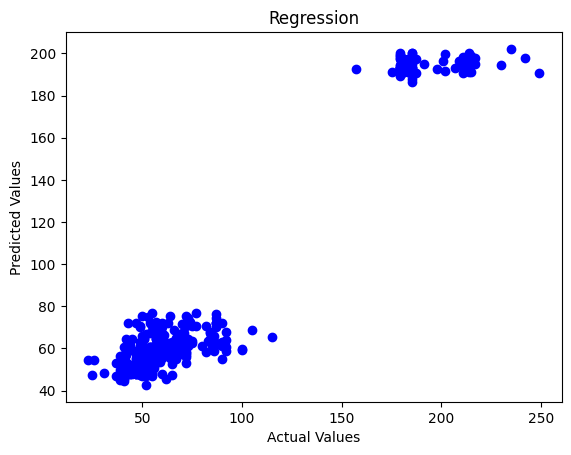

10/10 [==============================] - 0s 3ms/step
[[ 0 21  4  0  3  0  0]
 [ 0 23 10  0  8  0  0]
 [ 0 18 30  0 18  0  0]
 [ 0  4 19  0 13  0  0]
 [ 0  0 11  0 41  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


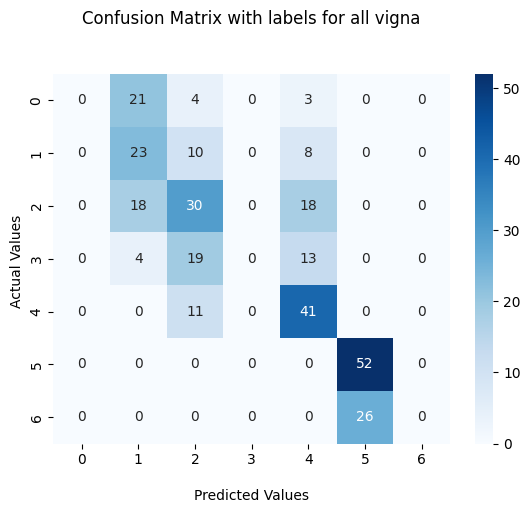

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/80
9/9 [==============================] - 0s 22ms/step - loss: 3.1277 - Classification_loss: 1.2772 - Regression_loss: 6.5837 - Classification_accuracy: 0.4198 - Regression_mse: 334.1535 - val_loss: 2.8630 - val_Classification_loss: 1.2623 - val_Regression_loss: 5.3268 - val_Classification_accuracy: 0.4733 - val_Regression_mse: 215.3221
Epoch 2/80
9/9 [==============================] - 0s 10ms/step - loss: 3.1896 - Classification_loss: 1.2735 - Regression_loss: 6.9477 - Classification_accuracy: 0.4466 - Regression_mse: 365.2945 - val_loss: 2.7738 - val_Classification_loss: 1.2629 - val_Regression_loss: 4.7989 - val_Classification_accuracy: 0.3969 - val_Regression_mse: 141.1551
Epoch 3/80
9/9 [==============================] - 0s 10ms/step - loss: 3.1612 - Classification_loss: 1.2263 - Regression_loss: 6.9711 - Classification_accuracy: 0.4771 - Regression_mse: 379.5631 - val_loss: 2.

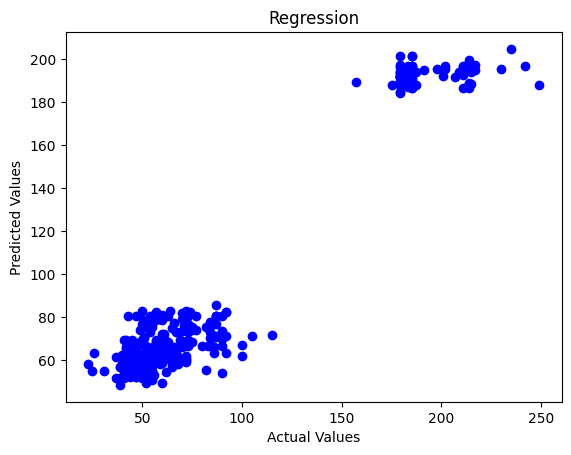

10/10 [==============================] - 0s 2ms/step
[[ 4  0 22  0  2  0  0]
 [ 3  0 32  0  6  0  0]
 [ 2  0 51  0 13  0  0]
 [ 0  0 27  0  9  0  0]
 [ 0  0 24  0 28  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


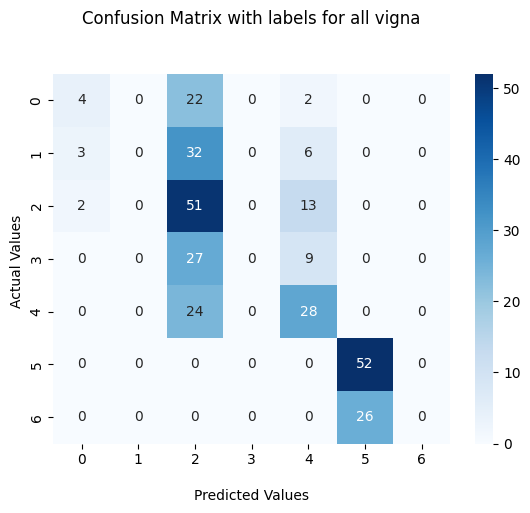

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/80
9/9 [==============================] - 0s 17ms/step - loss: 3.1089 - Classification_loss: 1.2152 - Regression_loss: 6.9175 - Classification_accuracy: 0.4618 - Regression_mse: 393.9960 - val_loss: 2.8278 - val_Classification_loss: 1.3621 - val_Regression_loss: 4.8402 - val_Classification_accuracy: 0.2748 - val_Regression_mse: 149.2774
Epoch 2/80
9/9 [==============================] - 0s 11ms/step - loss: 2.9607 - Classification_loss: 1.1998 - Regression_loss: 6.2379 - Classification_accuracy: 0.4466 - Regression_mse: 294.6352 - val_loss: 2.7343 - val_Classification_loss: 1.3632 - val_Regression_loss: 4.3956 - val_Classification_accuracy: 0.2901 - val_Regression_mse: 129.0211
Epoch 3/80
9/9 [==============================] - 0s 10ms/step - loss: 3.0980 - Classification_loss: 1.2198 - Regression_loss: 6.8346 - Classification_accuracy: 0.4561 - Regression_mse: 373.4791 - val_loss: 2.

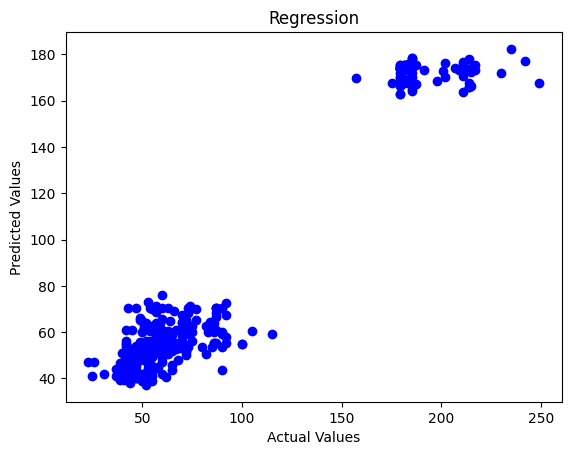

10/10 [==============================] - 0s 3ms/step
[[ 0 21  5  0  2  0  0]
 [ 0 23 12  0  6  0  0]
 [ 0 18 28  0 20  0  0]
 [ 0  3 21  0 12  0  0]
 [ 0  0 19  0 33  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


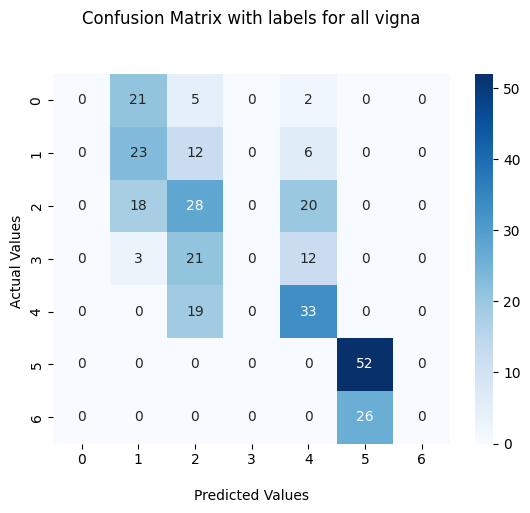

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/80
9/9 [==============================] - 0s 17ms/step - loss: 3.0708 - Classification_loss: 1.2463 - Regression_loss: 6.7380 - Classification_accuracy: 0.4714 - Regression_mse: 346.0322 - val_loss: 3.2526 - val_Classification_loss: 1.4498 - val_Regression_loss: 6.6850 - val_Classification_accuracy: 0.2595 - val_Regression_mse: 242.4789
Epoch 2/80
9/9 [==============================] - 0s 12ms/step - loss: 3.1259 - Classification_loss: 1.2272 - Regression_loss: 7.0695 - Classification_accuracy: 0.4332 - Regression_mse: 373.8245 - val_loss: 2.7906 - val_Classification_loss: 1.3334 - val_Regression_loss: 4.8797 - val_Classification_accuracy: 0.4046 - val_Regression_mse: 147.4237
Epoch 3/80
9/9 [==============================] - 0s 10ms/step - loss: 3.0691 - Classification_loss: 1.2160 - Regression_loss: 6.8438 - Classification_accuracy: 0.4905 - Regression_mse: 372.6241 - val_loss: 2.

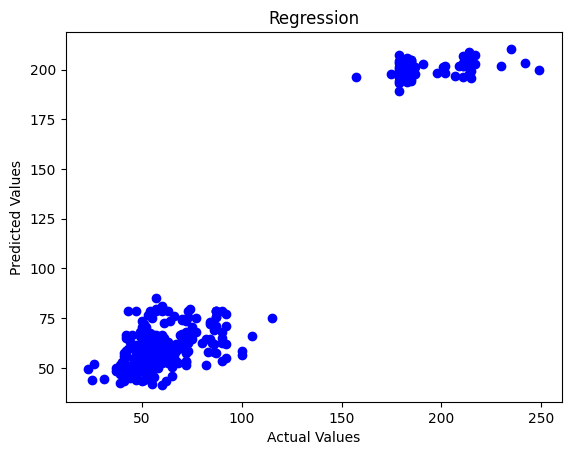

10/10 [==============================] - 0s 2ms/step
[[ 1  0 24  0  3  0  0]
 [ 1  0 32  0  8  0  0]
 [ 1  0 38  0 27  0  0]
 [ 0  0 19  0 17  0  0]
 [ 0  0 14  0 38  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


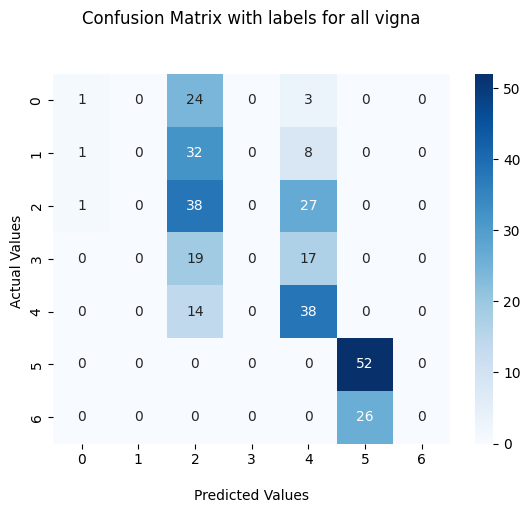

------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/80
9/9 [==============================] - 0s 17ms/step - loss: 3.0074 - Classification_loss: 1.2080 - Regression_loss: 6.6368 - Classification_accuracy: 0.4427 - Regression_mse: 347.3215 - val_loss: 2.6823 - val_Classification_loss: 1.3478 - val_Regression_loss: 4.4351 - val_Classification_accuracy: 0.3206 - val_Regression_mse: 127.3730
Epoch 2/80
9/9 [==============================] - 0s 10ms/step - loss: 3.0119 - Classification_loss: 1.2090 - Regression_loss: 6.6627 - Classification_accuracy: 0.4408 - Regression_mse: 358.4480 - val_loss: 3.0772 - val_Classification_loss: 1.4548 - val_Regression_loss: 5.9228 - val_Classification_accuracy: 0.2748 - val_Regression_mse: 199.2299
Epoch 3/80
9/9 [==============================] - 0s 11ms/step - loss: 3.0040 - Classification_loss: 1.1863 - Regression_loss: 6.7192 - Classification_accuracy: 0.4523 - Regression_mse: 373.8592 - val_loss: 2.

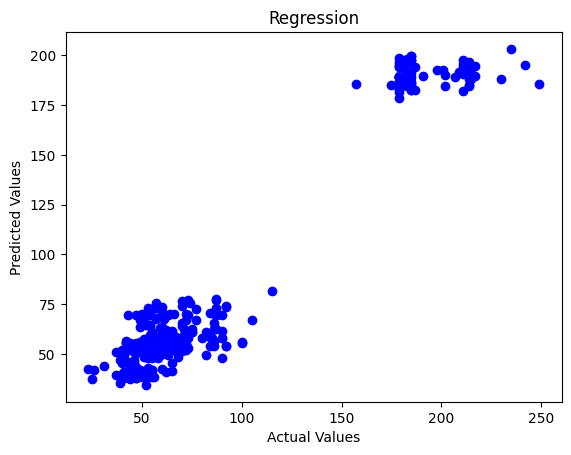

10/10 [==============================] - 0s 2ms/step
[[ 0 23  4  0  1  0  0]
 [ 0 31  4  4  2  0  0]
 [ 0 35  8 14  9  0  0]
 [ 0 15  7  8  6  0  0]
 [ 0 11  3 22 16  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


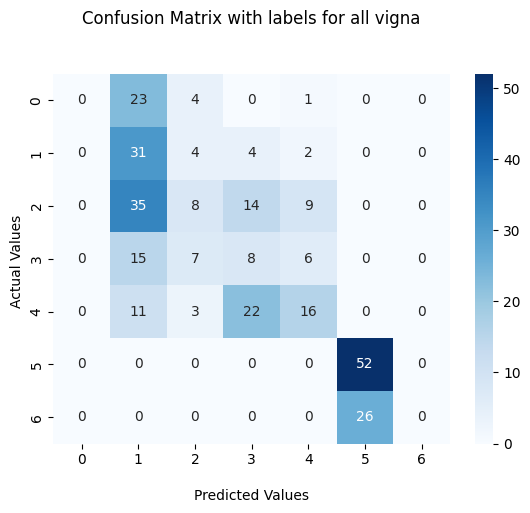

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/80
9/9 [==============================] - 0s 17ms/step - loss: 3.0043 - Classification_loss: 1.2336 - Regression_loss: 6.5276 - Classification_accuracy: 0.4294 - Regression_mse: 331.8311 - val_loss: 2.9138 - val_Classification_loss: 1.3962 - val_Regression_loss: 5.4249 - val_Classification_accuracy: 0.2901 - val_Regression_mse: 205.9021
Epoch 2/80
9/9 [==============================] - 0s 11ms/step - loss: 3.0114 - Classification_loss: 1.1750 - Regression_loss: 6.8057 - Classification_accuracy: 0.4771 - Regression_mse: 364.1277 - val_loss: 2.6793 - val_Classification_loss: 1.3043 - val_Regression_loss: 4.5985 - val_Classification_accuracy: 0.3893 - val_Regression_mse: 138.0442
Epoch 3/80
9/9 [==============================] - 0s 11ms/step - loss: 3.0234 - Classification_loss: 1.1844 - Regression_loss: 6.8374 - Classification_accuracy: 0.4485 - Regression_mse: 343.5352 - val_loss: 2.

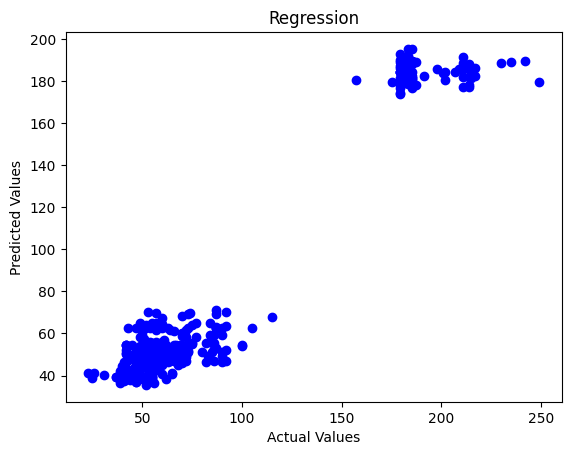

10/10 [==============================] - 0s 3ms/step
[[ 0  0 27  0  1  0  0]
 [ 0  0 38  0  3  0  0]
 [ 0  0 57  0  9  0  0]
 [ 0  0 32  0  4  0  0]
 [ 0  0 37  0 15  0  0]
 [ 0  0  0  0  0 50  2]
 [ 0  0  0  0  0 25  1]]


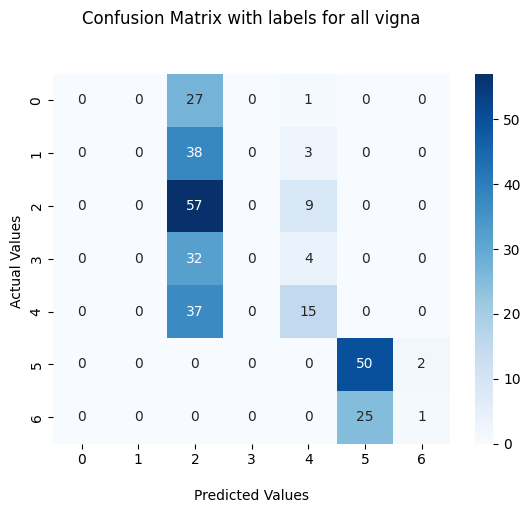

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/80
9/9 [==============================] - 0s 18ms/step - loss: 2.9276 - Classification_loss: 1.1748 - Regression_loss: 6.4574 - Classification_accuracy: 0.4714 - Regression_mse: 337.0278 - val_loss: 2.7743 - val_Classification_loss: 1.4533 - val_Regression_loss: 4.5637 - val_Classification_accuracy: 0.3206 - val_Regression_mse: 145.8596
Epoch 2/80
9/9 [==============================] - 0s 12ms/step - loss: 2.9648 - Classification_loss: 1.1740 - Regression_loss: 6.6541 - Classification_accuracy: 0.4370 - Regression_mse: 357.8416 - val_loss: 3.0854 - val_Classification_loss: 1.4529 - val_Regression_loss: 6.0782 - val_Classification_accuracy: 0.3969 - val_Regression_mse: 221.2430
Epoch 3/80
9/9 [==============================] - 0s 12ms/step - loss: 3.0010 - Classification_loss: 1.2111 - Regression_loss: 6.6943 - Classification_accuracy: 0.4599 - Regression_mse: 353.7029 - val_loss: 2.

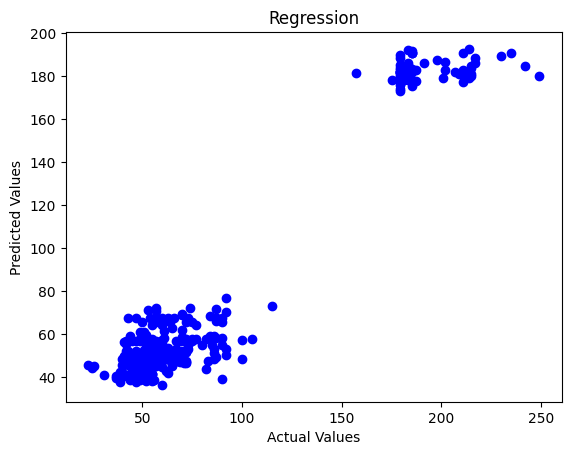

10/10 [==============================] - 0s 4ms/step
[[10  0 15  3  0  0  0]
 [13  0 20  8  0  0  0]
 [13  0 29 22  2  0  0]
 [ 0  0 22 13  1  0  0]
 [ 0  0 19 29  4  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


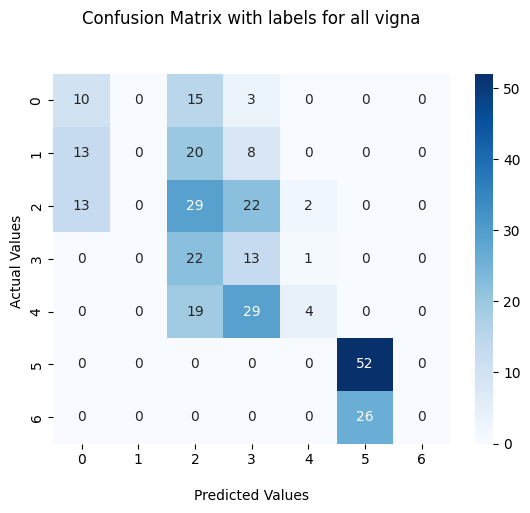

------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/80
9/9 [==============================] - 0s 27ms/step - loss: 2.9283 - Classification_loss: 1.1588 - Regression_loss: 6.5796 - Classification_accuracy: 0.5095 - Regression_mse: 329.9471 - val_loss: 2.8387 - val_Classification_loss: 1.4047 - val_Regression_loss: 5.0990 - val_Classification_accuracy: 0.3893 - val_Regression_mse: 160.5202
Epoch 2/80
9/9 [==============================] - 0s 17ms/step - loss: 2.9681 - Classification_loss: 1.1624 - Regression_loss: 6.7544 - Classification_accuracy: 0.4809 - Regression_mse: 371.2582 - val_loss: 2.6647 - val_Classification_loss: 1.3180 - val_Regression_loss: 4.6271 - val_Classification_accuracy: 0.4275 - val_Regression_mse: 154.1345
Epoch 3/80
9/9 [==============================] - 0s 16ms/step - loss: 2.9222 - Classification_loss: 1.1564 - Regression_loss: 6.5748 - Classification_accuracy: 0.4924 - Regression_mse: 346.9785 - val_loss: 2.

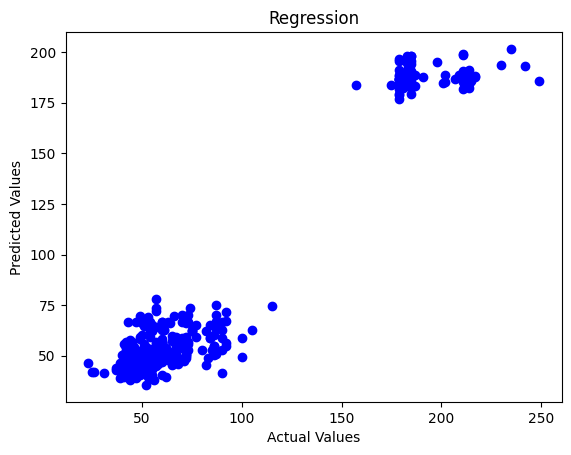

10/10 [==============================] - 0s 3ms/step
[[ 0 17 10  0  1  0  0]
 [ 0 17 18  0  6  0  0]
 [ 0 14 38  1 13  0  0]
 [ 0  3 26  0  7  0  0]
 [ 0  1 23  2 26  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


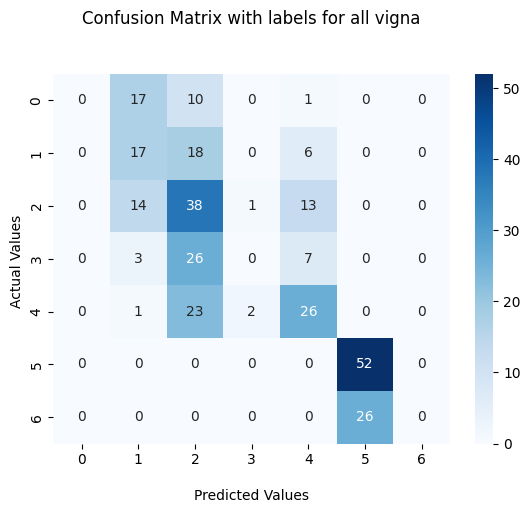

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/80
9/9 [==============================] - 0s 25ms/step - loss: 2.9048 - Classification_loss: 1.1811 - Regression_loss: 6.4150 - Classification_accuracy: 0.4752 - Regression_mse: 330.2542 - val_loss: 2.7567 - val_Classification_loss: 1.4462 - val_Regression_loss: 4.5779 - val_Classification_accuracy: 0.2748 - val_Regression_mse: 145.2504
Epoch 2/80
9/9 [==============================] - 0s 17ms/step - loss: 2.7746 - Classification_loss: 1.1246 - Regression_loss: 5.9741 - Classification_accuracy: 0.4695 - Regression_mse: 274.8216 - val_loss: 3.0831 - val_Classification_loss: 1.5129 - val_Regression_loss: 5.8938 - val_Classification_accuracy: 0.2672 - val_Regression_mse: 208.8315
Epoch 3/80
9/9 [==============================] - 0s 19ms/step - loss: 2.8889 - Classification_loss: 1.1264 - Regression_loss: 6.5393 - Classification_accuracy: 0.4943 - Regression_mse: 352.6061 - val_loss: 2

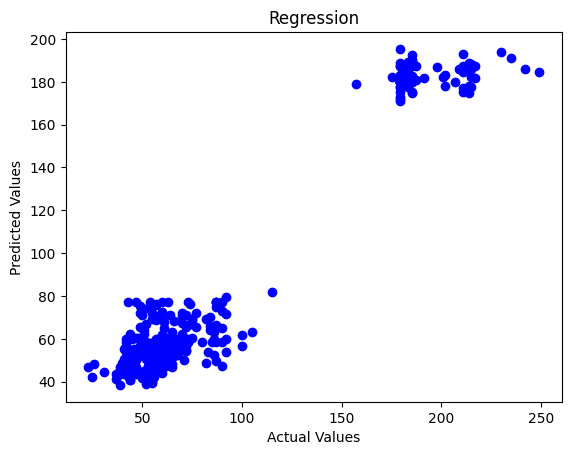

10/10 [==============================] - 0s 3ms/step
[[ 0 11 16  0  1  0  0]
 [ 0 16 19  0  6  0  0]
 [ 0 13 42  0 11  0  0]
 [ 0  0 29  0  7  0  0]
 [ 0  0 26  0 26  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


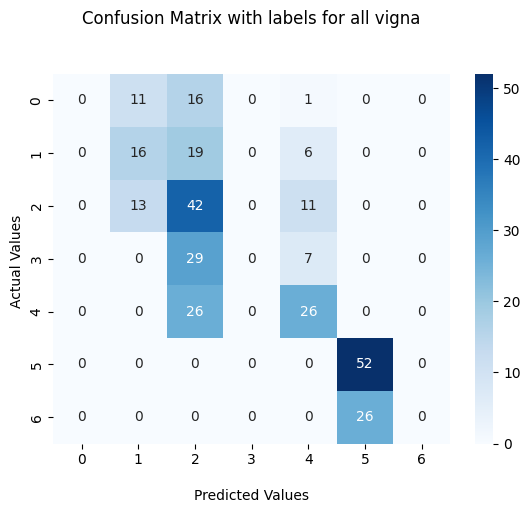

------------------------------------------------------------------------
Training for fold 11 ...
Epoch 1/80
9/9 [==============================] - 0s 18ms/step - loss: 2.8807 - Classification_loss: 1.1338 - Regression_loss: 6.5318 - Classification_accuracy: 0.5038 - Regression_mse: 353.4551 - val_loss: 2.8105 - val_Classification_loss: 1.3496 - val_Regression_loss: 5.3046 - val_Classification_accuracy: 0.3893 - val_Regression_mse: 206.5999
Epoch 2/80
9/9 [==============================] - 0s 14ms/step - loss: 2.8497 - Classification_loss: 1.1703 - Regression_loss: 6.2358 - Classification_accuracy: 0.4714 - Regression_mse: 303.8667 - val_loss: 2.7463 - val_Classification_loss: 1.4247 - val_Regression_loss: 4.6806 - val_Classification_accuracy: 0.3511 - val_Regression_mse: 154.8740
Epoch 3/80
9/9 [==============================] - 0s 13ms/step - loss: 2.9165 - Classification_loss: 1.1867 - Regression_loss: 6.5008 - Classification_accuracy: 0.4618 - Regression_mse: 343.9243 - val_loss: 2

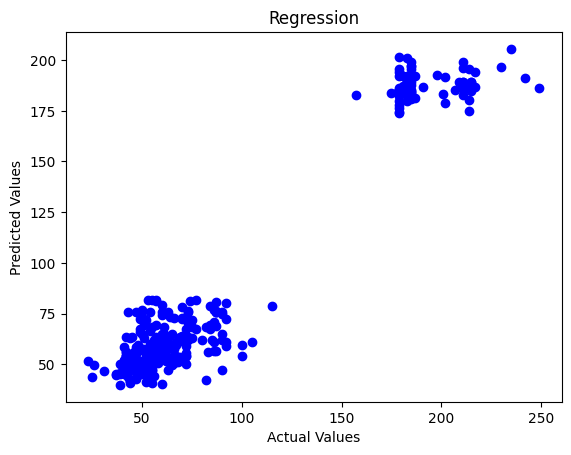

10/10 [==============================] - 0s 3ms/step
[[ 3  7 16  0  2  0  0]
 [ 3 10 21  0  7  0  0]
 [ 6  5 37  0 18  0  0]
 [ 0  0 25  0 11  0  0]
 [ 0  2 20  0 30  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


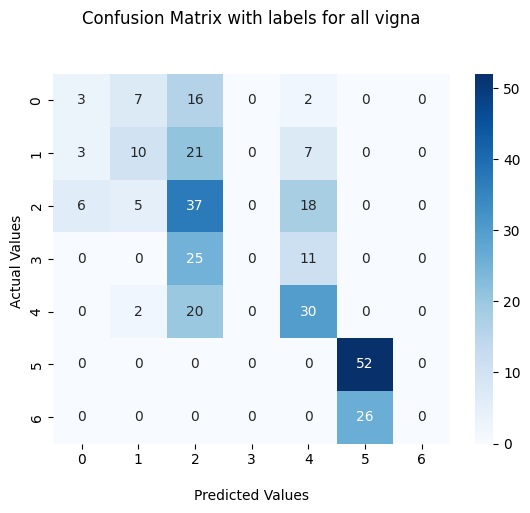

------------------------------------------------------------------------
Training for fold 12 ...
Epoch 1/80
9/9 [==============================] - 0s 19ms/step - loss: 2.9085 - Classification_loss: 1.1886 - Regression_loss: 6.4431 - Classification_accuracy: 0.4656 - Regression_mse: 336.0214 - val_loss: 2.7004 - val_Classification_loss: 1.3655 - val_Regression_loss: 4.6769 - val_Classification_accuracy: 0.3740 - val_Regression_mse: 156.3314
Epoch 2/80
9/9 [==============================] - 0s 14ms/step - loss: 2.8143 - Classification_loss: 1.1454 - Regression_loss: 6.1423 - Classification_accuracy: 0.5000 - Regression_mse: 280.1949 - val_loss: 2.7992 - val_Classification_loss: 1.3961 - val_Regression_loss: 5.0355 - val_Classification_accuracy: 0.4122 - val_Regression_mse: 172.6482
Epoch 3/80
9/9 [==============================] - 0s 13ms/step - loss: 2.7932 - Classification_loss: 1.1729 - Regression_loss: 5.9192 - Classification_accuracy: 0.4695 - Regression_mse: 281.5881 - val_loss: 2

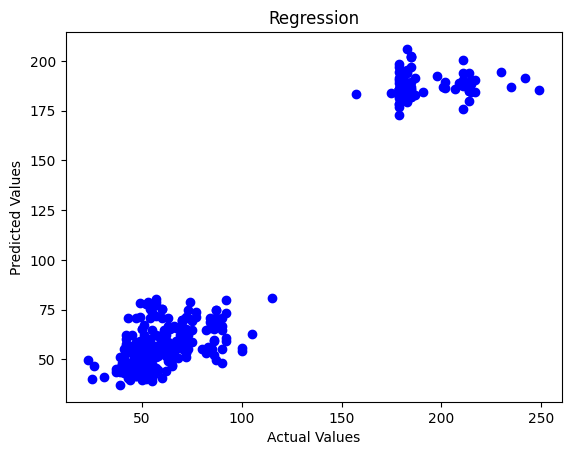

10/10 [==============================] - 0s 5ms/step
[[ 8  0 19  0  1  0  0]
 [10  0 26  0  5  0  0]
 [ 8  0 43  0 15  0  0]
 [ 0  0 27  0  9  0  0]
 [ 0  0 26  0 26  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


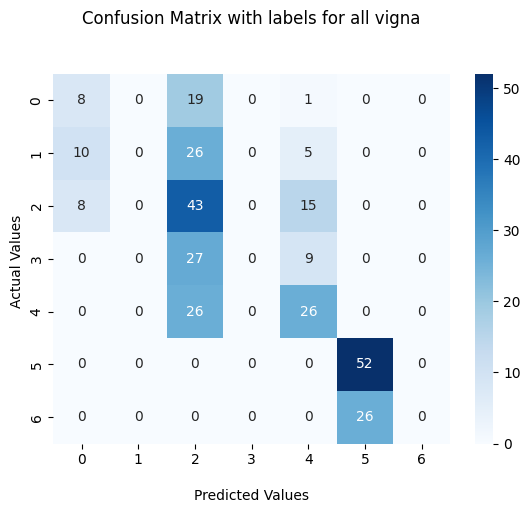

------------------------------------------------------------------------
Training for fold 13 ...
Epoch 1/80
9/9 [==============================] - 0s 41ms/step - loss: 2.8783 - Classification_loss: 1.1387 - Regression_loss: 6.5197 - Classification_accuracy: 0.5134 - Regression_mse: 379.0784 - val_loss: 2.7754 - val_Classification_loss: 1.4789 - val_Regression_loss: 4.6467 - val_Classification_accuracy: 0.3106 - val_Regression_mse: 159.9846
Epoch 2/80
9/9 [==============================] - 0s 18ms/step - loss: 2.7443 - Classification_loss: 1.1163 - Regression_loss: 5.9582 - Classification_accuracy: 0.5057 - Regression_mse: 299.3475 - val_loss: 3.2573 - val_Classification_loss: 1.5514 - val_Regression_loss: 6.6362 - val_Classification_accuracy: 0.3182 - val_Regression_mse: 270.4899
Epoch 3/80
9/9 [==============================] - 0s 16ms/step - loss: 2.8943 - Classification_loss: 1.1698 - Regression_loss: 6.4751 - Classification_accuracy: 0.4809 - Regression_mse: 330.6206 - val_loss: 2

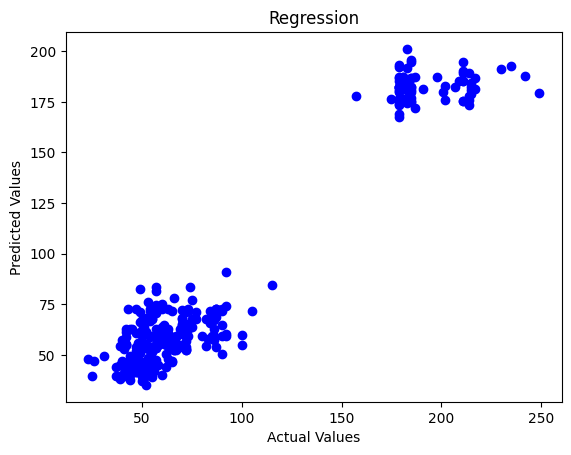

10/10 [==============================] - 0s 3ms/step
[[ 7 16  2  1  2  0  0]
 [ 8 22  1  2  8  0  0]
 [ 6 25  1 12 22  0  0]
 [ 0 16  2  7 11  0  0]
 [ 0 11  1  4 36  0  0]
 [ 0  0  0  0  0 21 31]
 [ 0  0  0  0  0  8 18]]


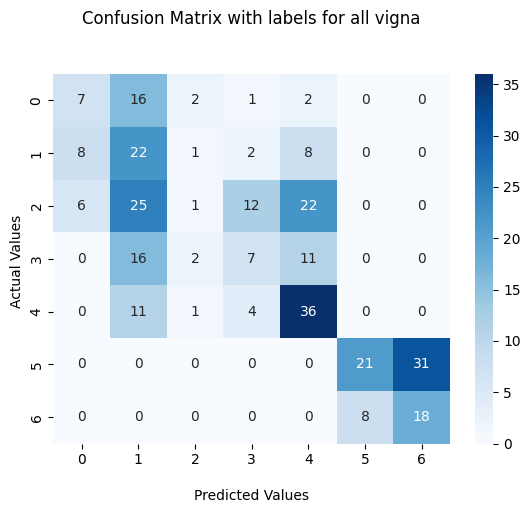

------------------------------------------------------------------------
Training for fold 14 ...
Epoch 1/80
9/9 [==============================] - 0s 19ms/step - loss: 2.8821 - Classification_loss: 1.1061 - Regression_loss: 6.6759 - Classification_accuracy: 0.5229 - Regression_mse: 380.1813 - val_loss: 2.9228 - val_Classification_loss: 1.4759 - val_Regression_loss: 5.3635 - val_Classification_accuracy: 0.3939 - val_Regression_mse: 182.2132
Epoch 2/80
9/9 [==============================] - 0s 13ms/step - loss: 2.7907 - Classification_loss: 1.1304 - Regression_loss: 6.1158 - Classification_accuracy: 0.5134 - Regression_mse: 299.2123 - val_loss: 3.0026 - val_Classification_loss: 1.4562 - val_Regression_loss: 5.8033 - val_Classification_accuracy: 0.4242 - val_Regression_mse: 209.0180
Epoch 3/80
9/9 [==============================] - 0s 16ms/step - loss: 2.8614 - Classification_loss: 1.1251 - Regression_loss: 6.4754 - Classification_accuracy: 0.5172 - Regression_mse: 340.6874 - val_loss: 2

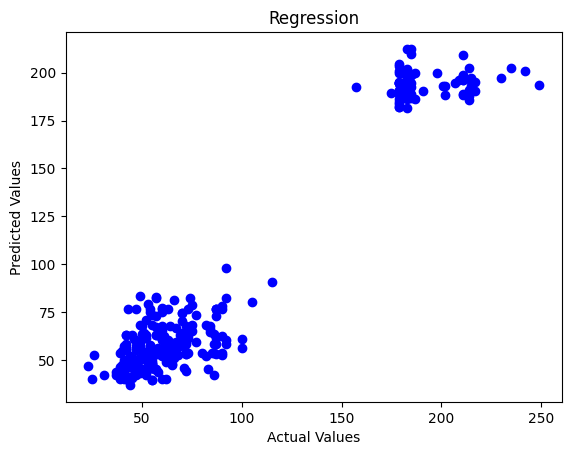

10/10 [==============================] - 0s 3ms/step
[[ 7  6  8  6  1  0  0]
 [ 6 15  6 11  3  0  0]
 [ 5 12 13 25 11  0  0]
 [ 1  4  5 21  5  0  0]
 [ 3  1  5 25 18  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


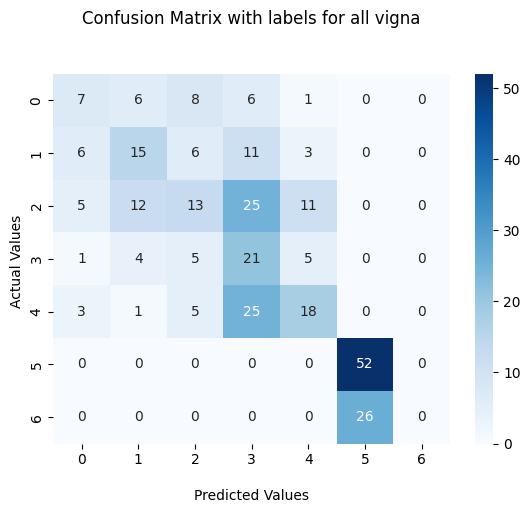

------------------------------------------------------------------------
Training for fold 15 ...
Epoch 1/80
9/9 [==============================] - 0s 20ms/step - loss: 2.7561 - Classification_loss: 1.0998 - Regression_loss: 6.0552 - Classification_accuracy: 0.5134 - Regression_mse: 317.2425 - val_loss: 3.0181 - val_Classification_loss: 1.4876 - val_Regression_loss: 5.7514 - val_Classification_accuracy: 0.3939 - val_Regression_mse: 204.7202
Epoch 2/80
9/9 [==============================] - 0s 16ms/step - loss: 2.8281 - Classification_loss: 1.1334 - Regression_loss: 6.2686 - Classification_accuracy: 0.5305 - Regression_mse: 340.4987 - val_loss: 2.5969 - val_Classification_loss: 1.3062 - val_Regression_loss: 4.4410 - val_Classification_accuracy: 0.4394 - val_Regression_mse: 138.4977
Epoch 3/80
9/9 [==============================] - 0s 14ms/step - loss: 2.7476 - Classification_loss: 1.0986 - Regression_loss: 6.0325 - Classification_accuracy: 0.5115 - Regression_mse: 305.9569 - val_loss: 2

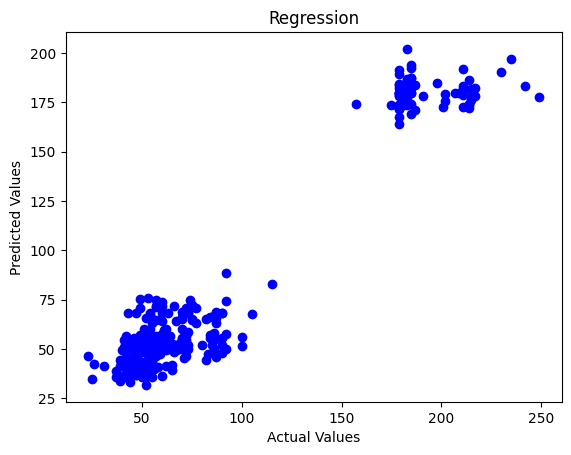

10/10 [==============================] - 0s 3ms/step
[[ 7  8 12  0  1  0  0]
 [ 5 13 17  0  6  0  0]
 [ 5  9 32  0 20  0  0]
 [ 0  3 22  0 11  0  0]
 [ 0  1 19  0 32  0  0]
 [ 0  0  0  0  0 52  0]
 [ 0  0  0  0  0 26  0]]


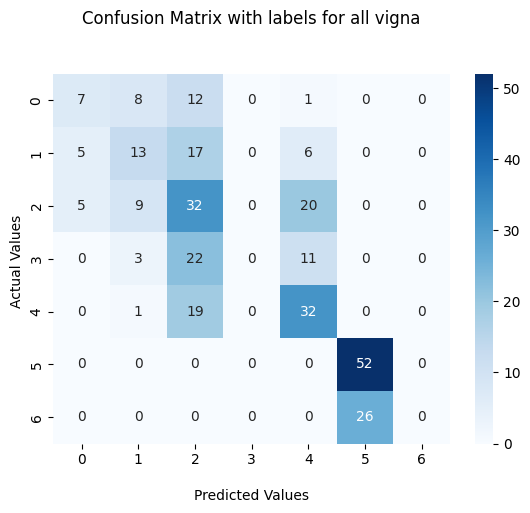

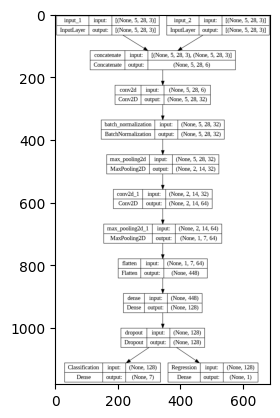

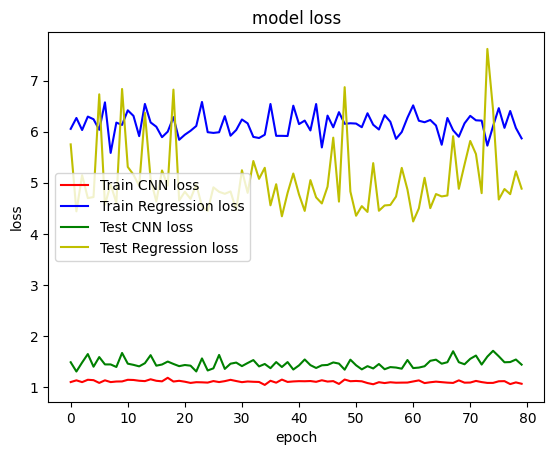

Accuracy in all folds: [40.425533056259155, 44.68085169792175, 48.93617033958435, 40.425533056259155, 40.425533056259155, 36.17021143436432, 48.93617033958435, 44.68085169792175, 44.68085169792175, 46.80851101875305, 46.80851101875305, 51.06382966041565, 50.0, 36.95652186870575, 45.652174949645996]
C loss in all folds: [1.196305274963379, 1.172257900238037, 1.2063922882080078, 1.5370497703552246, 1.312300443649292, 1.3451300859451294, 1.2278028726577759, 1.3457525968551636, 1.1685123443603516, 1.3847529888153076, 1.4206815958023071, 1.180785059928894, 1.1654822826385498, 1.3324838876724243, 1.3908790349960327]
Huber in all folds: [5.639152526855469, 4.569741249084473, 5.743840217590332, 6.098826885223389, 4.131936073303223, 6.209482192993164, 5.073548793792725, 5.063683032989502, 4.807977676391602, 5.078631401062012, 4.07047176361084, 4.117188453674316, 4.379777908325195, 4.883436679840088, 5.236580848693848]
MSE in all folds: [233.92910766601562, 124.41917419433594, 195.33444213867188

In [12]:
train()